In [1]:
import tensorflow as tf
from Dive_into_deep_learning.d2l import tensorflow as d2l

2023-08-08 16:26:45.627721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        
        init_weight = lambda *shape: tf.Variable(tf.random.normal(shape) * sigma)
        triple = lambda : (init_weight(num_inputs, num_hiddens),
                           init_weight(num_hiddens, num_hiddens),
                           tf.Variable(tf.zeros(num_hiddens)))
        
        self.W_xr, self.W_hr, self.b_r = triple() # Reset gate
        self.W_xz, self.W_hz, self.b_z = triple() # Update gate
        self.W_xh, self.W_hh, self.b_h = triple() # Candidate hidden state
    
    def forward(self, inputs, H=None):
        if H is None:
            # Initial state with shape: (batch, num_hiddens)
            H = tf.zeros((inputs.shape[1], self.num_hiddens))
            
        outputs = []
        for X in inputs:
            R = tf.sigmoid(tf.matmul(X, self.W_xr) + tf.matmul(H, self.W_hr) + self.b_r)
            Z = tf.sigmoid(tf.matmul(X, self.W_xz) + tf.matmul(H, self.W_hz) + self.b_z)
            H_tilde = tf.tanh(tf.matmul(X, self.W_xh) + tf.matmul(R * H, self.W_hh) + self.b_h)
            H = Z * H + (1 - Z) * H_tilde
            outputs.append(H)
            
        return outputs, H

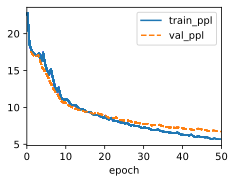

In [3]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)

trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1)
trainer.fit(model, data)

In [5]:
model.predict('it has', 20, data.vocab)

'it has a matter the the th'

# Concise Implementation

In [4]:
class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = tf.keras.layers.GRU(num_hiddens, return_sequences=True, return_state=True)

In [ ]:
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [ ]:
model.predict('it has', 20, data.vocab)